## Librerías:

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Visualización y métricas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from SupportFunc.Loader import MultiLabelImageDataset
from SupportFunc.AdaptiveAttention import AdaptiveAttention, AdaptiveTransformerEncoderLayer
from SupportFunc.Visualization import plot_confusion_matrix, plot_train_val_curve

## Parámetros y funciones:

In [2]:
# En el modelo AdaptiveAttentionClassifierWithCLIP
class AdaptiveAttentionClassifierWithCLIP(nn.Module):
    def __init__(self, clip_model, num_classes, seq_len=1):
        super(AdaptiveAttentionClassifierWithCLIP, self).__init__()
        self.clip_model = clip_model
        self.seq_len = seq_len
        self.image_embed = nn.Linear(512, 512)  # Embedding de CLIP al transformador
        self.transformer_encoder = nn.ModuleList([
            AdaptiveTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(6)
        ])
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, image_features):
        # Ajustar dimensiones (expandir artificialmente para seq_len)
        image_embeddings = image_features.unsqueeze(1).repeat(1, self.seq_len, 1)  # [batch_size, seq_len, 512]

        # Pasar por el Transformer
        for layer in self.transformer_encoder:
            image_embeddings = layer(image_embeddings)

        # Clasificación final
        output = self.mlp(image_embeddings[:, 0, :])  # Usar solo el primer token para la clasificación
        return output


In [3]:
# Obtener el directorio actual
current_directory = os.getcwd()
data_directory = os.path.join(current_directory[:-3], 'data')
images_directory = os.path.join(data_directory, 'images')

num_epochs = 1
batch_size = 32
lr = 0.001 
image_feature_dim = 2048

# Crear subset basado en los nombres de archivos en la carpeta de imágenes
subset = [os.path.splitext(filename)[0] for filename in os.listdir(images_directory)]
print(len(subset))

# Transformaciones para las imágenes
transform_clip = transforms.Compose([ transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     ])

302


## Carga de datos:

### Selección de subset para pruebas:

In [4]:
# Leer y filtrar datos
train_1 = pd.read_csv(f'{data_directory}/train_data.csv')
test_1 = pd.read_csv(f'{data_directory}/test_data.csv')

train_1 = train_1[train_1['ID'].isin(subset)]
test_1 = test_1[test_1['ID'].isin(subset)]

# Guardar los archivos filtrados
train_1.to_csv(f'{data_directory}/train_data_2.csv', encoding='utf-8', index=False)
test_1.to_csv(f'{data_directory}/test_data_2.csv', encoding='utf-8', index=False)

# Crear datasets y DataLoaders
train_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/train_data_2.csv", img_dir=f"{images_directory}/", transform=transform_clip)
test_dataset = MultiLabelImageDataset(csv_file=f"{data_directory}/test_data_2.csv", img_dir=f"{images_directory}/", transform=transform_clip)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Instanciar modelo:

In [5]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo CLIP
clip_model_name = "openai/clip-vit-base-patch32"  # Cambia el modelo si usas otro.
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# Asegúrate de mover el modelo CLIP al dispositivo adecuado (GPU o CPU)
clip_model = clip_model.to(device)

# Descongelar las capas para fine-tuning
for param in clip_model.parameters():
    param.requires_grad = True

# Crear modelo con atención adaptativa
model = AdaptiveAttentionClassifierWithCLIP(clip_model=clip_model, num_classes=train_dataset[0][1].size(0))
model = model.to(device)

# Configuración del optimizador y función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

## Entrenamiento:

In [8]:
# Entrenamiento
train_losses = list()
val_losses = list()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        # Mover imágenes y etiquetas al dispositivo
        images, labels = images.to(device), labels.to(device)
        
        # Convertir imágenes a formato adecuado para CLIP
        images = [transforms.ToPILImage()(img) for img in images]  # Convertir tensores a imágenes PIL
        image_inputs = clip_processor(images=images, return_tensors="pt", padding=True)
        image_inputs = {key: val.to(device) for key, val in image_inputs.items()}

        # Obtener embeddings de imagen desde CLIP
        with torch.no_grad():
            image_features = clip_model.get_image_features(**image_inputs)

        # Pasar las características al modelo con atención adaptativa
        outputs = model(image_features)
        loss = criterion(outputs, labels)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            # Mover imágenes y etiquetas al dispositivo
            images, labels = images.to(device), labels.to(device)
            images = [transforms.ToPILImage()(img) for img in images]
            image_inputs = clip_processor(images=images, return_tensors="pt", padding=True)
            image_inputs = {key: val.to(device) for key, val in image_inputs.items()}
            image_features = clip_model.get_image_features(**image_inputs)

            outputs = model(image_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Imprimir métricas
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/1, Train Loss: 0.2160, Val Loss: 0.2047


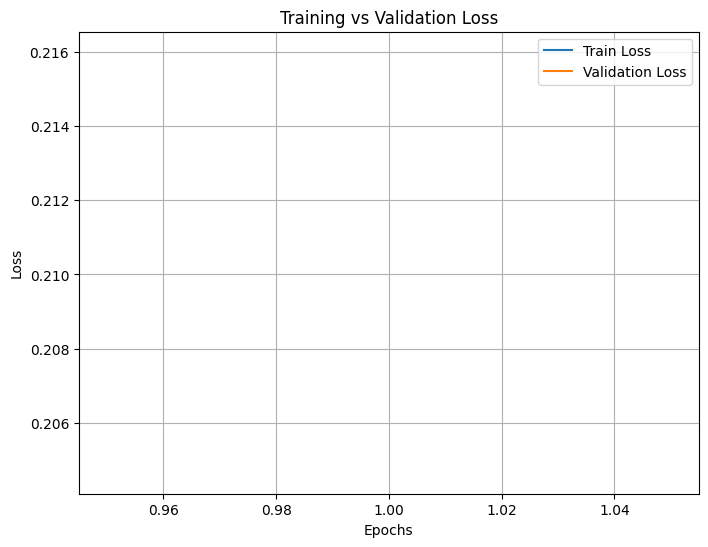

In [9]:
plot_train_val_curve(num_epochs, train_losses, val_losses)

## Inferencia y métricas: